In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

# 生成数据集

In [2]:
def synthetic_data(w, b, num_examples):  # num_examples: 样本数量
    """生成y=Xw+b+噪声"""
    
    """
    torch.normal(means, std, out=None): 
    normal：正态分布。
    返回一个张量，包含从给定参数means,std的离散正态分布中抽取随机数。 
    均值means: 是一个张量，包含每个输出元素相关的正态分布的均值。 
    std: 是一个张量，包含每个输出元素相关的正态分布的标准差。 
    均值和标准差的形状不须匹配，但每个张量的元素个数须相同。
    """
    
    X = torch.normal(0, 1, (num_examples, len(w)))  # 生成均值为0，方差为1的随机数，共生成num_examples个样本的随机数，每个样本的列数等于w的长度
    y = torch.matmul(X, w) + b  # torch.matmul(): 矩阵相乘
    y += torch.normal(0, 0.01, y.shape)  # 加入随机噪音（均值为0，方差为0.01）
    return X, y.reshape((-1, 1))  # y.reshape((-1, 1)): 把y转化为列向量返回

true_w = torch.tensor([2, -3.4])  # w的真实值
true_b = 4.2  # b的真实值
features, labels = synthetic_data(true_w, true_b, 1000)  # 生成1000个样本

In [3]:
print('features:', features[0],'\nlabel:', labels[0])  # features：二维数据样本， labels：标签值

features: tensor([0.5873, 1.1367]) 
label: tensor([1.5072])


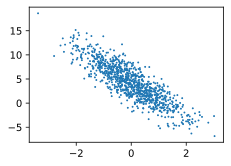

In [4]:
# d2l.set_figsize(width, height): 设置 matplotlib 绘图库中的图形大小，不给参数时默认值为宽度为4英寸，高度为3英寸
d2l.set_figsize()
# features[:, 1]选择了features张量的第二列数据作为x轴的值，然后将它们从张量中分离出来，并将它们转换为numpy数组。
# labels张量则作为y轴的值。这个散点图使用点的大小为1，表示每个点的大小相同
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

# 读取数据集

In [5]:
def data_iter(batch_size, features, labels):  # 读取小批量
    num_examples = len(features)  # 计算数据集中的样本数量即样本的行数
    indices = list(range(num_examples))  # 创建了一个从 0 到 num_examples-1 的索引列表，用于对数据进行洗牌并创建小批量。（所有样本的索引）
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)  # 将索引随机洗牌，以便从数据的随机子集创建小批量。
    for i in range(0, num_examples, batch_size):  #以 batch_size 的步长循环遍历索引，以此定义小批量。
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])  # 选择当前小批量的一部分索引。使用 min 函数确保最后一个小批量不会超过数据集中的样本数量。
        yield features[batch_indices], labels[batch_indices]

In [6]:
batch_size = 10  # 小批量个数设为10

for X, y in data_iter(batch_size, features, labels):  # 打印小批量样本及其标签值
    print(X, '\n', y)
    break

tensor([[-0.6944, -0.9782],
        [-0.3026, -0.2321],
        [ 0.6075,  1.4822],
        [ 1.1611,  0.1550],
        [ 1.3381, -0.4074],
        [ 1.6147,  0.0819],
        [ 0.0514, -0.6953],
        [-0.1967,  1.8263],
        [ 0.7678,  2.3174],
        [-1.4454,  0.4500]]) 
 tensor([[ 6.1299],
        [ 4.3865],
        [ 0.3750],
        [ 6.0031],
        [ 8.2762],
        [ 7.1607],
        [ 6.6684],
        [-2.4113],
        [-2.1354],
        [-0.2115]])


# 初始化模型参数

In [7]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)  # 设置张量的requires_grad属性为True，表示需要计算梯度以进行反向传播
b = torch.zeros(1, requires_grad=True)

# 定义模型

In [8]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

# 定义损失函数

In [9]:
def squared_loss(y_hat, y):  #@save  y_hat:预测值， y:真实
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

# 定义优化算法

In [10]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():  # 下面代码中不进行梯度计算
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()  # 因为grad是累加的，所以每次计算完一批的梯度时要置0

# 训练

In [11]:
lr = 0.03
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.037076
epoch 2, loss 0.000135
epoch 3, loss 0.000052
epoch 4, loss 0.000052
epoch 5, loss 0.000053
epoch 6, loss 0.000052
epoch 7, loss 0.000052
epoch 8, loss 0.000052
epoch 9, loss 0.000052
epoch 10, loss 0.000052


In [12]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')  # print(f'...{}...'): 字符串输出，{}中为变量
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([1.2791e-04, 1.2875e-05], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0002], grad_fn=<RsubBackward1>)
